# 1. Standard GAN

In [ ]:
from PIL import Image
from IPython.display import display

def display_image(image_path):
  with Image.open(image_path) as img:
      # Resize the image
      new_width = 300
      aspect_ratio = img.height / img.width
      new_height = int(aspect_ratio * new_width)
      img_resized = img.resize((new_width, new_height))

      # Display the resized image
      display(img_resized)


In [ ]:
display_image("/content/gan1.png")

In [ ]:
display_image("/content/gan2.png")

<img src="https://www.researchgate.net/publication/349182009/figure/fig2/AS:1021198364327941@1620484071612/Typical-Generative-Adversarial-Networks-GAN-architecture.png" width="600" alt="Typical GAN Architecture">


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

global_seed = 123
np.random.seed(global_seed)
tf.random.set_seed(global_seed)


In [2]:
(X_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
# Use sample dataset

num_train = 10000
idxs = np.arange(X_train.shape[0])
np.random.shuffle(idxs)
X_train = X_train[idxs][:num_train]
y_train = y_train[idxs][:num_train]

In [ ]:
class GAN:
    def __init__(self, X= None, batch_size=32, epochs=10, optimizer=tf.keras.optimizers.legacy.Adam(0.01), noise_dim=30):
        super(GAN, self).__init__()
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.noise_dim = noise_dim
        self.generator = None
        self.discriminator = None
        self.gan = None
        self.dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(1000)
        self.dataset= self.dataset.batch(self.batch_size).prefetch(1)

    @staticmethod
    def plot_multiple_images(images, n_cols=None):
        n_cols = n_cols or len(images)
        n_rows = (len(images) - 1) // n_cols + 1
        if images.shape[-1] == 1:
            images = np.squeeze(images, axis=-1)
        plt.figure(figsize=(n_cols, n_rows))
        for index, image in enumerate(images):
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(image, cmap="binary")
            plt.axis("off")
        plt.show()

    def build(self):
        pass

    def generate(self, num_examples= None):
        num_examples= self.batch_size if num_examples is None else num_examples
        z = tf.random.normal(shape=[num_examples, self.noise_dim])
        X_gen = self.generator(z)
        return X_gen

    def train(self):
        batch_per_epoch = tf.data.experimental.cardinality(self.dataset).numpy()
        self.history = {'disc-loss': [], 'gen-loss': []}
        for epoch in range(self.epochs):
            d_losses = []
            g_losses = []
            progress_bar_train = tf.keras.utils.Progbar(batch_per_epoch)
            for batch, X_batch in zip(range(batch_per_epoch), self.dataset):
                # PHASE 1 - training the discriminator
                z = tf.random.normal(shape=[X_batch.shape[0], self.noise_dim])
                X_gen = self.generator(z)
                X_fake_and_real = tf.concat([X_gen, X_batch], axis=0)
                y1 = tf.constant([[0.]] * X_gen.shape[0] + [[1.]] * X_batch.shape[0])
                self.discriminator.trainable = True
                d_loss_batch = self.discriminator.train_on_batch(X_fake_and_real, y1)
                d_losses.append(d_loss_batch)
                # PHASE 2 - training the generator
                z = tf.random.normal(shape=[self.batch_size, self.noise_dim])
                y2 = tf.constant([[1.]] * self.batch_size)
                self.discriminator.trainable = False
                g_loss_batch= self.gan.train_on_batch(z, y2)
                g_losses.append(g_loss_batch)
                if(batch % 25 ==0):
                    progress_bar_train.add(25, values=[('d loss', d_loss_batch), ('g loss', g_loss_batch)])
            print("Epoch {}/{}: disc-loss = {}, gen-loss = {}".format(epoch + 1, self.epochs, np.mean(d_losses), np.mean(g_losses)))
            self.history['disc-loss'].append(np.mean(d_losses))
            self.history['gen-loss'].append(np.mean(g_losses))
            GAN.plot_multiple_images(self.generate()[:4*8], 8)


In [ ]:
class StandardGAN(GAN):
    def __init__(self, X= None, batch_size=32, epochs=10, optimizer=tf.keras.optimizers.legacy.Adam(0.01), noise_dim=30):
        super(StandardGAN, self).__init__(X, batch_size, epochs, optimizer, noise_dim)

    def build(self):
        self.generator = keras.models.Sequential([
            keras.layers.Dense(100, activation="selu", input_shape=[self.noise_dim]),
            keras.layers.Dense(150, activation="selu"),
            keras.layers.Dense(28 * 28, activation="sigmoid"),
            keras.layers.Reshape([28, 28])])

        self.discriminator = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[28, 28]),
            keras.layers.Dense(150, activation="selu"),
            keras.layers.Dense(100, activation="selu"),
            keras.layers.Dense(1, activation="sigmoid")])
        self.gan = keras.models.Sequential([self.generator, self.discriminator])

        self.discriminator.compile(loss="binary_crossentropy", optimizer= self.optimizer)
        self.discriminator.trainable = False
        self.gan.compile(loss="binary_crossentropy", optimizer= self.optimizer)

In [ ]:
standard_GAN = StandardGAN(X=X_train, batch_size=128, noise_dim=100, optimizer=tf.keras.optimizers.legacy.RMSprop(), epochs=30)

In [ ]:
standard_GAN.build()

In [ ]:
standard_GAN.train()

In [ ]:
plt.plot(standard_GAN.history['disc-loss'], "--^")
plt.show()

In [ ]:
plt.plot(standard_GAN.history['gen-loss'], "--o")
plt.show()

# 2. DCGAN

<img src="https://raw.githubusercontent.com/JoannaBroniarek/DCGAN-for-MRI-images/6a72e1581bb73e12cfc9e794be98b1364f13fa03//docs/dcgan.png" width="900" alt="Typical GAN Architecture">


In [ ]:
class DCGAN(GAN):
    def __init__(self, X= None, batch_size=32, epochs=10, optimizer=tf.keras.optimizers.legacy.Adam(0.01), noise_dim=30):
        super(DCGAN, self).__init__(X, batch_size, epochs, optimizer, noise_dim)

    def build(self):
        self.generator = keras.models.Sequential([
            keras.layers.Dense(7 * 7 * 128, input_shape=[self.noise_dim]),
            keras.layers.Reshape([7, 7, 128]),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")])

        self.discriminator = keras.models.Sequential([keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
                                                      keras.layers.Dropout(0.4),
                                                      keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
                                                      keras.layers.Dropout(0.4),
                                                      keras.layers.Flatten(),
                                                      keras.layers.Dense(1, activation="sigmoid")])

        self.gan = keras.models.Sequential([self.generator, self.discriminator])

        self.discriminator.compile(loss="binary_crossentropy", optimizer=self.optimizer)
        self.discriminator.trainable = False
        self.gan.compile(loss="binary_crossentropy", optimizer=self.optimizer)

In [ ]:
X_train_3D = X_train.reshape([-1, 28, 28, 1])* 2. - 1.

In [ ]:
X_train_3D.shape

In [ ]:
dc_GAN = DCGAN(X=X_train_3D, batch_size=128, noise_dim=100, epochs=30, optimizer=tf.keras.optimizers.legacy.RMSprop())

In [ ]:
dc_GAN.build()

In [ ]:
dc_GAN.train()

In [ ]:
plt.plot(dc_GAN.history['disc-loss'], "--^")
plt.show()

In [ ]:
plt.plot(dc_GAN.history['gen-loss'], "--^")
plt.show()

# 3. Wasserstein GAN with Gradient Penalty

In [5]:
from PIL import Image
from IPython.display import display

def display_image(image_path):
  with Image.open(image_path) as img:
      # Resize the image
      new_width = 500
      aspect_ratio = img.height / img.width
      new_height = int(aspect_ratio * new_width)
      img_resized = img.resize((new_width, new_height))

      # Display the resized image
      display(img_resized)


<img src="https://miro.medium.com/v2/resize:fit:1400/1*5jF5gbIDwU6k9m1ILl0Utg.jpeg" width="900" alt="Typical GAN Architecture">


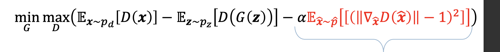

In [6]:
display_image('/content/wgan1.png')

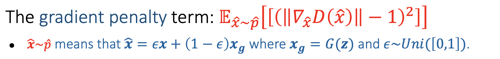

In [7]:
display_image('/content/wgan2.png')

In [8]:
class WassersteinGAN_GP:
    def __init__(self, X= None, batch_size=32, epochs=10, d_optimizer=tf.keras.optimizers.legacy.RMSprop(0.001),
                 g_optimizer=tf.keras.optimizers.legacy.RMSprop(0.001), noise_dim=64, n_train_g=2, alpha=10.0):
        self.batch_size = batch_size
        self.epochs = epochs
        self.noise_dim = noise_dim
        self.generator = None
        self.discriminator = None
        self.gan = None
        self.dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(1000)
        self.dataset= self.dataset.batch(self.batch_size).prefetch(1)
        self.alpha= alpha
        self.d_optimizer= d_optimizer
        self.g_optimizer= g_optimizer
        self.n_train_g = n_train_g

    @staticmethod
    def plot_multiple_images(images, n_cols=None):
        n_cols = n_cols or len(images)
        n_rows = (len(images) - 1) // n_cols + 1
        if images.shape[-1] == 1:
            images = np.squeeze(images, axis=-1)
        plt.figure(figsize=(n_cols, n_rows))
        for index, image in enumerate(images):
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(image, cmap="binary")
            plt.axis("off")


    def build(self):
        self.generator = keras.models.Sequential([tf.keras.layers.Dense(7 * 7 * 128, input_shape=[self.noise_dim]),
                                                  tf.keras.layers.Reshape([7, 7, 128]),
                                                  tf.keras.layers.BatchNormalization(),
                                                  tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
                                                  tf.keras.layers.BatchNormalization(),
                                                  tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")])

        self.discriminator = keras.models.Sequential([tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
                                                      tf.keras.layers.Dropout(0.4),
                                                      tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
                                                      tf.keras.layers.Dropout(0.4),
                                                      tf.keras.layers.Flatten(),
                                                      tf.keras.layers.Dense(1, activation="tanh")])

        self.gan = keras.models.Sequential([self.generator, self.discriminator])

    def gradient_penalty(self, X, X_gen):
        eps = tf.random.uniform([X.shape[0],1,1,1], minval=0, maxval=1)
        X_hat = eps*X + (1.0-eps)*X_gen
        with tf.GradientTape(persistent=True) as g:
            g.watch(X_hat)
            d_x_hat = self.discriminator(X_hat)
        grads = g.gradient(d_x_hat, X_hat)
        grad_norm = tf.sqrt(tf.reduce_sum(grads ** 2, axis=[1, 2]))
        gp = tf.reduce_mean((grad_norm-1)**2)
        return gp


    def compute_losses(self, X):
        z = tf.random.normal(shape=[X.shape[0], self.noise_dim])
        X_gen = self.generator(z)
        d_gp = self.gradient_penalty(X, X_gen)
        d_loss = -tf.reduce_mean(self.discriminator(X_gen), axis=0) + tf.reduce_mean(self.discriminator(X), axis=0) \
                  + self.alpha*d_gp
        g_loss = tf.reduce_mean(self.discriminator(X_gen), axis=0)
        return d_loss, g_loss

    def compute_gradients(self, X):
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            d_loss, g_loss = self.compute_losses(X)
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        return d_grads, g_grads

    def compute_gradient_g(self, X):
        with tf.GradientTape() as g_tape:
            z = tf.random.normal(shape=[X.shape[0], self.noise_dim])
            X_gen = self.generator(z)
            g_loss = tf.reduce_mean(self.discriminator(X_gen), axis=0)
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        return g_grads


    def train_one_batch(self, X):
        d_grads, g_grads= self.compute_gradients(X)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        for i in range(self.n_train_g-1):
            g_grads = self.compute_gradient_g(X)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

    def generate(self, num_examples= None):
        num_examples= self.batch_size if num_examples is None else num_examples
        z = tf.random.normal(shape=[num_examples, self.noise_dim])
        X_gen = self.generator(z)
        return X_gen


    def train(self):
        self.history = {'d_loss':[], 'g_loss':[]}
        batch_per_epoch = tf.data.experimental.cardinality(self.dataset).numpy()
        for epoch in range(self.epochs):
            d_losses= []
            g_losses =[]
            progress_bar_train = tf.keras.utils.Progbar(batch_per_epoch)
            for batch, X_batch in zip(range(batch_per_epoch), self.dataset):
                self.train_one_batch(X_batch)
                d_loss_batch, g_loss_batch= self.compute_losses(X_batch)
                d_losses.append(d_loss_batch)
                g_losses.append(g_loss_batch)

                if(batch % 25 ==0):
                    progress_bar_train.add(25, values=[('d loss', d_loss_batch), ('g loss', g_loss_batch)])

            self.history['d_loss'].append(np.mean(d_losses))
            self.history['g_loss'].append(np.mean(g_losses))
            print("Epoch {}/{}: disc-loss= {}| gen-loss= {}".format(epoch + 1, self.epochs, np.mean(d_losses), np.mean(g_losses)))
            WassersteinGAN_GP.plot_multiple_images(self.generate()[:4*8], 8)
            plt.show()

In [9]:
X_train.shape

(10000, 28, 28)

In [11]:
X_train_3D = X_train.reshape([-1, 28, 28, 1])* 2. - 1.

In [12]:
X_train_3D.shape

(10000, 28, 28, 1)

In [13]:
ws_gan = WassersteinGAN_GP(X_train_3D, batch_size=32, epochs=20)

In [14]:
ws_gan.build()

In [15]:
ws_gan.train()

Output hidden; open in https://colab.research.google.com to view.

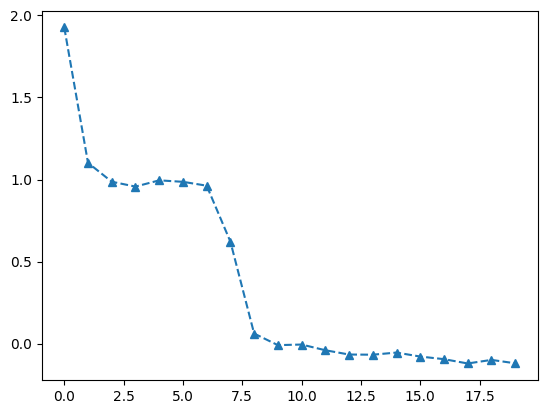

In [16]:
plt.plot(ws_gan.history['d_loss'], "--^")
plt.show()

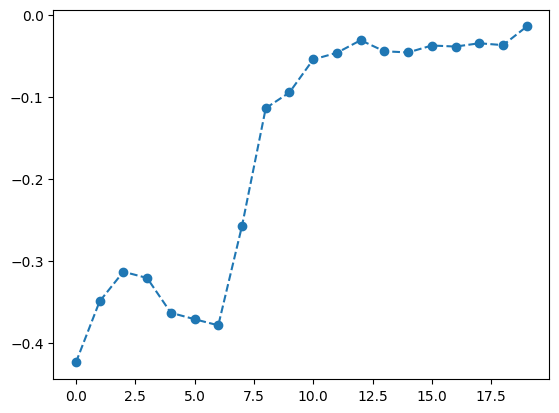

In [17]:
plt.plot(ws_gan.history['g_loss'], "--o")
plt.show()

# Test Generating Image

In [ ]:
num_images = 5  # Number of images you want to generate
generated_images = standard_GAN.generate(num_examples=num_images)

# Display the generated images
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
num_images = 5  # Number of images you want to generate
generated_images = dc_GAN.generate(num_examples=num_images)

# Display the generated images
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()


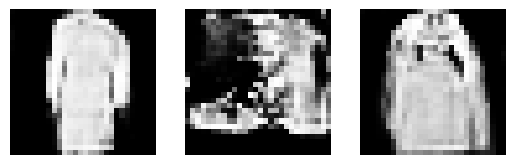

In [22]:
num_images = 3  # Number of images you want to generate
generated_images = ws_gan.generate(num_examples=num_images)

# Display the generated images
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()
